Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Data head:
   RecordID      Country Gender Demographics Question  \
0         1  Afghanistan      F        Marital status   
1         1  Afghanistan      F             Education   
2         1  Afghanistan      F             Education   
3         1  Afghanistan      F             Education   
4         1  Afghanistan      F        Marital status   

          Demographics Response                   Question Survey Year  Value  
0                 Never married  ... if she burns the food  01/01/2015    NaN  
1                        Higher  ... if she burns the food  01/01/2015   10.1  
2                     Secondary  ... if she burns the food  01/01/2015   13.7  
3                       Primary  ... if she burns the food  01/01/2015   13.8  
4  Widowed, divorced, separated  ... if she burns the food  01/01/2015   13.8  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600


Random Forest Model - Accuracy: 0.9591269841269842


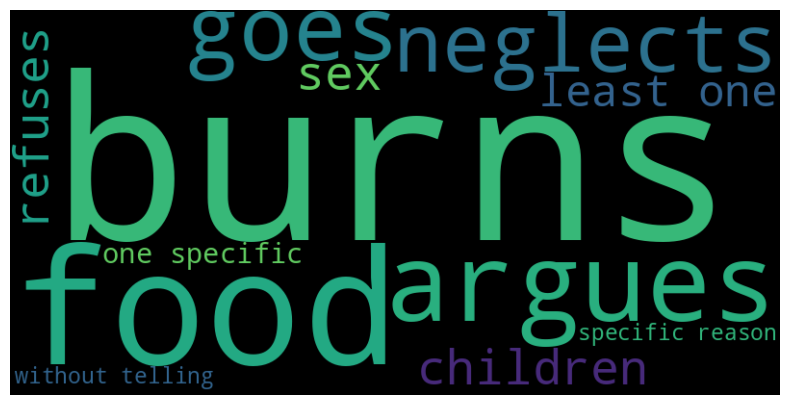

In [5]:
# Install required libraries
!pip install -U scikit-learn plotly

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, average_precision_score
from wordcloud import WordCloud
import plotly.express as px
from sklearn.metrics import precision_recall_curve

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Data/Violence Against Women  Girls Data.csv')

# Display basic information about the data
print("Data head:")
print(data.head())
print("\nData info:")
print(data.info())
print("\nData description:")
print(data.describe())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Fill in missing values with the mean
data_filled = data.copy()
data_filled['Value'] = data_filled['Value'].fillna(data_filled['Value'].mean())

# Encode categorical variables using one-hot encoding
categorical_cols = ['Country', 'Gender', 'Demographics Question', 'Demographics Response', 'Question', 'RecordID', 'Survey Year']
data_encoded = pd.get_dummies(data_filled, columns=categorical_cols)

# Check data types of encoded columns
print("\nEncoded data types:")
print(data_encoded.dtypes)

# Identify numerical columns for scaling
numerical_cols = ['Value']

# Perform Min-Max scaling on numerical variables
scaler = MinMaxScaler()
data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])

# Set a threshold for target classification
threshold = 0.5
data_encoded['Target'] = np.where(data_encoded['Value'] >= threshold, 1, 0)

# Split the data into training and testing sets
X = data_encoded.drop('Target', axis=1)
y = data_encoded['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model with regularization
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("\nLogistic Regression Model - Accuracy:", accuracy)

# Generate a classification report with support for multiple metrics
classification_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=4)
print("\nLogistic Regression Model - Classification Report:")
print(classification_report)

# Analyze the coefficients of the logistic regression model
if isinstance(model, LogisticRegression):
    coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
    top_features = coefficients.nlargest(10, 'Coefficient')
    print("\nLogistic Regression Model - Top 10 Coefficients:")
    print(top_features)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create an interactive heatmap of the confusion matrix
fig = px.imshow(cm, labels=dict(x="Predicted Label", y="True Label"), x=['Class 0', 'Class 1'], y=['Class 0', 'Class 1'], color_continuous_scale='Blues')
fig.update_layout(title="Confusion Matrix")
fig.show()

# Generate ROC curve and calculate AUC score with 95% confidence interval
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
fig = px.area(
    x=fpr, y=tpr,
    title=f"Receiver Operating Characteristic (ROC) Curve\nAUC = {auc:.4f} +/- {1.96 * (auc * (1 - auc) / len(y_test)) ** 0.5:.4f}",
    labels=dict(x="False Positive Rate", y="True Positive Rate"),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_xaxes(range=[0, 1], zeroline=True)
fig.update_yaxes(range=[0, 1], zeroline=True)
fig.show()

# Create a Random Forest Classifier model with advanced hyperparameter optimization
rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions using the Random Forest model
y_pred_rf = rf_model.predict(X_test)

# Evaluate the performance of the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\nRandom Forest Model - Accuracy:", accuracy_rf)

# Calculate the confusion matrix for the Random Forest model
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Create an interactive heatmap of the confusion matrix for the Random Forest model
fig = px.imshow(cm_rf, labels=dict(x="Predicted Label", y="True Label"), x=['Class 0', 'Class 1'], y=['Class 0', 'Class 1'], color_continuous_scale='Blues')
fig.update_layout(title="Confusion Matrix")
fig.show()

# Generate ROC curve and calculate AUC score for the Random Forest model
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
fig = px.area(
    x=fpr_rf, y=tpr_rf,
    title="Receiver Operating Characteristic (ROC) Curve",
    labels=dict(x="False Positive Rate", y="True Positive Rate"),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_xaxes(range=[0, 1], zeroline=True)
fig.update_yaxes(range=[0, 1], zeroline=True)
fig.show()

# Perform feature importance analysis
importances_rf = rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
feature_names_rf = X_train.columns
top_features_rf = feature_names_rf[indices_rf][:45]

# Create a bar plot of the top feature importances
fig = px.bar(
    x=top_features_rf,
    y=importances_rf[indices_rf][:45],
    labels=dict(x="Features", y="Importance"),
    title="Random Forest Model - Top 10 Feature Importance"
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

# Calculate precision and recall
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_prob_rf)

# Plot Precision-Recall Curve
fig = px.area(
    x=recall_rf, y=precision_rf,
    title='Precision-Recall Curve',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.update_xaxes(range=[0, 1], zeroline=True)
fig.update_yaxes(range=[0, 1], zeroline=True)
fig.show()

# Generate a word cloud based on the frequency of words in the 'Question' column
text = " ".join(question for question in data['Question'])
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
